##### Created on 06/02/2022

##### This notebook is to get the GCM wind vs M relationship for the oceans over 30N to 70N. Will be compared with MERRA2+MAC and PPE outputs. Improved from 'GCMwindVsM-daily'
##### Using myReadGCMsDaily function
##### Updated to plot bias vs resolution in cmip6
##### updated the merra2 surface folder to surface_old



### Conclusions:

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from myReadGCMsDaily import read_var_mod
import calendar
from global_land_mask import globe
import glob
import math
from scipy import stats
import netCDF4 as nc


In [99]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K
con= Rd/Cp

In [100]:
latr1 = 30
latr2 = 80

## My GCM read function

In [1]:
# import netCDF4 as nc
# import glob
# import numpy as np
# import xarray as xr
# import cftime

# pp_path_scratch='/glade/scratch/geethma/cmip6'

# def read_var_mod(level, modn, varnm, time1, time2):
#     path   = pp_path_scratch+'/'+level+'/'
    
#     ncname = modn+'.'+varnm
    
#     fn     = glob.glob(path+ncname+'*nc*')
#     f      = nc.Dataset(fn[0])
    
#     lat    = f.variables['lat']
#     lon    = f.variables['lon']
#     time   = f.variables['time']
#     times  = nc.num2date(time, f.variables['time'].units,calendar=f.variables['time'].calendar)

#     lev = []
    
#     if level=='p_level':
#         lev = f.variables['plev']
        
    
#     t1 = cftime.Datetime360Day(time1[0], time1[1], time1[2], 12, 0, 0, 0, has_year_zero=True)
#     t2 = cftime.Datetime360Day(time2[0], time2[1], time2[2], 12, 0, 0, 0, has_year_zero=True)

#     ind1 = np.array(np.where(times==t1))
#     ind1 = ind1[0,0]
    
#     ind2 = np.array(np.where(times==t2))
#     ind2 = ind2[0,0]
    
#     data   = f.variables[varnm][ind1:ind2+1,:,:]
    
    
#     return(lat,lon,times[ind1:ind2+1],lev,data)
    
    
    
    

# GCM

In [5]:
modname = ['CESM2','CESM2-WACCM','HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','CNRM-ESM2-1','INM-CM5-0','MPI-ESM1-2-HR','UKESM1-0-LL','MPI-ESM1-2-LR','MPI-ESM-1-2-HAM','CMCC-CM2-SR5','CMCC-CM2-HR4','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','IPSL-CM5A2-INCA']
varname = ['sfcWind', 'ts','psl'] #'sfcWind', 'hfss', 'hfls', 'tas', 'ps', 'psl',,'pr'
pvarname= ['ta']


In [5]:
l=0
m=1

In [6]:
time1=[2010, 1, 1]
time2=[2012, 12, 30]

In [7]:
# try:
for j in range(l,m): #
    print(modname[j])
    for i in varname:
        locals()[i+'__'+str(j+1)] = read_var_mod('surface', modname[j], 'historical', i, time1, time2)
        # print(i)
    for k in pvarname:
        locals()[k+'__'+str(j+1)] = read_var_mod('p_level', modname[j], 'historical', k, time1, time2)
        
# except IndexError:
#     print(str(j+1)+' not available')
print('done')    

CESM2


/glade/work/geethma/research/codes/myReadGCMsDaily.py:60: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  data.extend(np.array(datai[ind1:ind2+1,:,:]))


done


In [42]:
# i = l
for i in range(l,m):
    lat  = locals()['sfcWind__'+str(i+1)][0]
    lon  = locals()['sfcWind__'+str(i+1)][1]
    time = locals()['sfcWind__'+str(i+1)][2]

    for j in varname:
        locals()[j+str(i+1)] = locals()[j+'__'+str(i+1)][4]
        locals()[j+str(i+1)] = np.ma.filled(locals()[j+str(i+1)], fill_value=np.nan)
        print(np.shape(locals()[j+str(i+1)]))
# 
    for k in pvarname:
        locals()[k+str(i+1)] = locals()[k+'__'+str(i+1)][4]
        locals()[k+str(i+1)] = np.ma.filled(locals()[k+str(i+1)], fill_value=np.nan)
        print(np.shape(locals()[k+str(i+1)]))
        
        locals()['lev'+str(i+1)] = locals()['ta__'+str(i+1)][3]

(1094, 192, 288)
(1094, 192, 288)
(1094, 192, 288)
(1094, 8, 192, 288)


In [43]:
print(lev1[1], lev1[2])

85000.0 70000.0


In [44]:
print(len(time))
# print(time)

1094


Text(0.5, 0, 'CAOI [K]')

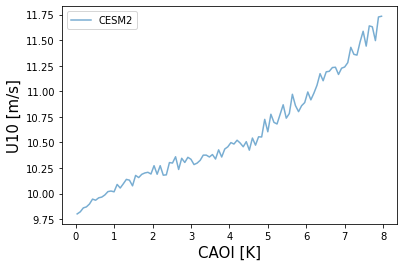

In [45]:
for i in range(l,m):
    x_lat = np.array(lat)
    lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
    lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]    
    lats = lat[lat_ind1[0]:lat_ind2[0]]

    x_lon = lon
    lon = np.array(lon)
    lon[lon > 180] = lon[lon > 180]-360
    
    maskm = np.ones((len(time),len(lats),len(lon)))

    for a in range(len(lats)):
        for b in range(len(lon)):
            if globe.is_land(lats[a], lon[b])==True:
                maskm[:,a,b] = math.nan
 
 ###  averaged theta at 800hPa and surface 
    theta_850 = locals()['ta'+str(i+1)][:,1,:,:]*(100000/85000)**con
    theta_700 = locals()['ta'+str(i+1)][:,2,:,:]*(100000/70000)**con
    theta_800 = theta_700 + ((2/3) * (theta_850 - theta_700))
    
    theta_sfc = locals()['ts'+str(i+1)]*(100000/locals()['psl'+str(i+1)])**con

### CAOI at 800hPa
    M = theta_sfc - theta_800
    
    x_sfcWind = locals()['sfcWind'+str(i+1)]
    m_sfcWind = x_sfcWind[:,lat_ind1[0]:lat_ind2[0],:]
    lats = lat[lat_ind1[0]:lat_ind2[0]]

    x_M = M
    m_M = x_M[:,lat_ind1[0]:lat_ind2[0],:]
    
    cao = np.array(m_M)
    sw  = np.array(m_sfcWind)
    
    plot_CAOI = np.array(np.multiply(maskm,cao))
    wind      = np.array(np.multiply(maskm,sw))
    
    pl_theta  = plot_CAOI.reshape(-1)
    pl_wind   = wind.reshape(-1)
    
    plo_theta = pl_theta[pl_theta>-40]
    plo_wind  = pl_wind[pl_theta>-40]
    
    plot_theta = plo_theta[plo_theta<40]
    plot_wind  = plo_wind[plo_theta<40]
    
    ind = np.argsort(plot_theta)
    xx = np.sort(plot_theta)
    yy = plot_wind[ind]
    
    g_indx = np.isnan(xx*yy)==False
    
    # plt.plot(xx[indx], yy[indx], label=modname[i], alpha=0.6)
    
    ######## U10 PDF ##################
#     from scipy.stats import norm
#     fig = plt.figure()
#     plt.plot(np.sort(yy[indx]), norm.pdf(np.sort(yy[indx])), label=modname[i])
#     # plt.legend()
#     plt.title(modname[i]+' - U10 PDF')
#     ######################################
    
#     ######## M PDF ##################
#     from scipy.stats import norm
#     fig = plt.figure()
#     plt.plot(xx[indx], norm.pdf(xx[indx]), label=modname[i])
#     # plt.legend()
#     plt.title(modname[i]+' - M PDF')
    ######################################
    
    
#     from scipy import stats

    g_M = xx[g_indx]
    g_W = yy[g_indx]
    
    #g_bin_means, g_bin_edges, g_binnumber = stats.binned_statistic(g_M, g_W, 'mean', bins=1000)
    g_W_bin_means, g_W_bin_edges, g_W_binnumber = stats.binned_statistic(g_M, g_W, 'mean', bins=100, range=(0,8))
    g_M_bin_means, g_M_bin_edges, g_M_binnumber = stats.binned_statistic(g_M, g_M, 'mean', bins=100, range=(0,8))

    g_index = np.isnan(g_M_bin_means*g_W_bin_means)==False
    
    plt.plot(g_M_bin_means[g_index], g_W_bin_means[g_index], label=modname[i], alpha=0.6)


plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('GCM - M PDF')
# plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N')
# plt.savefig('../figures/U10vsM_50S_50N.png')

In [13]:
np.max(g_M_bin_means[g_index])

9.949815499958966

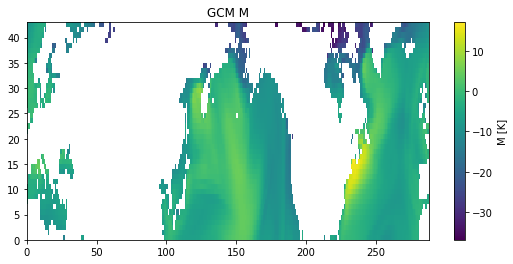

In [25]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(plot_CAOI[33,:,:])
plt.title('GCM M')
cbar = plt.colorbar()
cbar.set_label('M [K]')

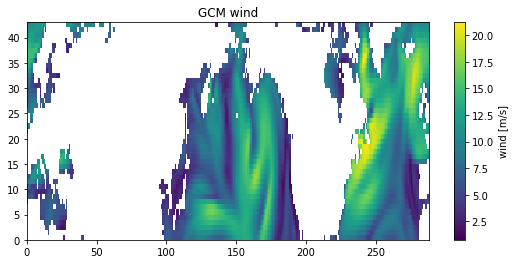

In [26]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(wind[33,:,:])
plt.title('GCM wind')
cbar = plt.colorbar()
cbar.set_label('wind [m/s]')

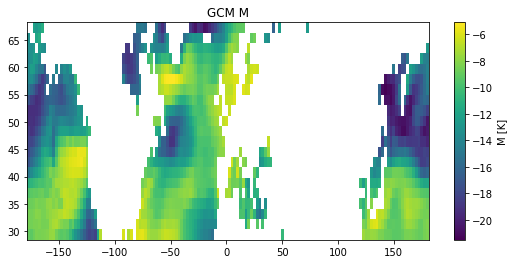

In [19]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(lon, lats, plot_CAOI[15,:,:])
plt.title('GCM M')
cbar = plt.colorbar()
cbar.set_label('M [K]')

In [10]:
# from skmisc.loess import loess
# index = np.isnan(bin_means_x*bin_means)==False

# # plt.plot(bin_means_x, bin_means)
# l = loess(bin_means_x[index], bin_means[index])
# l.fit()
# pred = l.predict(bin_means_x[index], stderror=True)
# conf = pred.confidence()

# lowess = pred.values
# plt.plot(bin_means_x[index], lowess)
# plt.ylabel('U10 [m/s]',fontsize='15')
# plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('GCM-CESM2')

In [ ]:
# bin_means_x_gcm = bin_means_x[index]
# bin_means_gcm   = lowess

In [ ]:
# x_gcm = []
# y_gcm = []


In [ ]:
# x_gcm.append(bin_means_x_gcm)
# y_gcm.append(bin_means_gcm)

# Observations

In [3]:
import glob
merlist = np.sort(glob.glob('../data_merra/all_lat_lon/level/MERRA2_*.nc'))
sfclist = np.sort(glob.glob('../data_merra/all_lat_lon/surface/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [114]:
for i in range(1): #len(merlist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    # print(d_path)
    
    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]


In [4]:
new_list_s = []
new_list_m = []

for i in range(2): #len(sfclist)
    name_s = os.path.basename(sfclist[i])
    date_s = name_s.split(".")[2]
    
    name_m = os.path.basename(merlist[i])
    date_m = name_m.split(".")[2]
    
    if date_s==date_m:
        new_list_s.append(sfclist[i])
        new_list_m.append(merlist[i])
    
    

NameError: name 'os' is not defined

In [137]:
date_m[-2:]

'6'

In [134]:
import netCDF4 as nc

p_mac_w = []

for i in range(2): #len(maclist)
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:] #(time,lat,lon)
    # print(ddpath)

    if i==0:
        maclat = ddata.variables['lat'][:]
        maclon = ddata.variables['lon'][:]
        mactime = ddata.variables['time'][:]
        #shape latitude
        mac_lat = np.array(maclat)
        slat_ind1 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr1)).argmin()])[0]
        slat_ind2 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr2)).argmin()])[0]
        p_mac_lat  = np.array(mac_lat[slat_ind1[0]:slat_ind2[0]])
        #shape longitude
        maclon[maclon > 180] = maclon[maclon > 180]-360
        # mac_lon = np.array(maclon)

    n_w = macw[:,slat_ind1[0]:slat_ind2[0],:]
    p_mac_w.extend(n_w)
print('p_mac_w', np.shape(p_mac_w))

p_mac_w (59, 50, 360)


In [135]:
mactime

masked_array(data=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                   28, 29, 30],
             mask=False,
       fill_value=999999,
            dtype=int16)

In [117]:
sfclist[0:5]

array(['../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100101.SUB.nc',
       '../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100102.SUB.nc',
       '../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100103.SUB.nc',
       '../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100104.SUB.nc',
       '../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100105.SUB.nc'],
      dtype='<U76')

In [115]:
print(len(merlist))
print(len(sfclist))
print(len(maclist))

1091
1081
36


In [97]:
import netCDF4 as nc

p_mac_w = []

for i in range(2): #len(maclist)
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:] #(time,lat,lon)
    # print(ddpath)

    if i==0:
        maclat = ddata.variables['lat'][:]
        maclon = ddata.variables['lon'][:]
        #shape latitude
        mac_lat = np.array(maclat)
        slat_ind1 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr1)).argmin()])[0]
        slat_ind2 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr2)).argmin()])[0]
        p_mac_lat  = np.array(mac_lat[slat_ind1[0]:slat_ind2[0]])
        #shape longitude
        maclon[maclon > 180] = maclon[maclon > 180]-360
        # mac_lon = np.array(maclon)

    n_w = macw[:,slat_ind1[0]:slat_ind2[0],:]
    p_mac_w.extend(n_w)
print('p_mac_w', np.shape(p_mac_w))

p_mac_w (59, 50, 360)


In [84]:
print(h-20)

406


In [89]:
h=h+1
print(merlist[h])
print(sfclist[h])

../data_merra/all_lat_lon/level/MERRA2_400.inst3_3d_asm_Np.20110313.SUB.nc
../data_merra/all_lat_lon/surface/MERRA2_400.inst1_2d_asm_Nx.20110314.SUB.nc


In [54]:
merlist[h-1]

'../data_merra/all_lat_lon/level/MERRA2_300.inst3_3d_asm_Np.20100804.SUB.nc'

In [55]:
sfclist[h-1]

'../data_merra/all_lat_lon/surface/MERRA2_300.inst1_2d_asm_Nx.20100804.SUB.nc'

In [15]:
import netCDF4 as nc
import xarray as xr
p_mer_T   = []
p_mac_w   = []
sfc_mer_T = []
sfc_mer_P = []

for i in range(len(merlist)): #len(merlist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    # print(d_path)
    
    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]
        #shape latitude
        mer_lat = np.flip(merlat)
        mer_lat = np.array(mer_lat)
        mlat_ind1 = np.where(mer_lat == mer_lat.flat[np.abs(mer_lat - (latr1)).argmin()])[0]
        mlat_ind2 = np.where(mer_lat == mer_lat.flat[np.abs(mer_lat - (latr2)).argmin()])[0]
        p_mer_lat  = np.array(mer_lat[mlat_ind1[0]:mlat_ind2[0]])
        #shape longitude
        merlon[merlon > 180] = merlon[merlon > 180]-360
        # mer_lon = np.array(merlon)
        
    merT   = data.variables['T'][:] #(time, lev, lat, lon)
    mer_T = np.array(merT[:,:,::-1,:])
    p_mer_T.extend(mer_T[:,:,mlat_ind1[0]:mlat_ind2[0],:])
    
temp = np.array(p_mer_T)

for i in range(len(sfclist)): #len(merlist)
    s_path = sfclist[i]
    sdata  = nc.Dataset(s_path)
    # print(d_path)
    
    if i==0:
        sfclat = sdata.variables['lat'][:]
        sfclon = sdata.variables['lon'][:]
        #shape latitude
        sfc_lat = np.flip(sfclat)
        sfc_lat = np.array(sfc_lat)
        flat_ind1 = np.where(sfc_lat == sfc_lat.flat[np.abs(sfc_lat - (latr1)).argmin()])[0]
        flat_ind2 = np.where(sfc_lat == sfc_lat.flat[np.abs(sfc_lat - (latr2)).argmin()])[0]
        p_sfc_lat  = np.array(sfc_lat[flat_ind1[0]:flat_ind2[0]])
        #shape longitude
        sfclon[sfclon > 180] = sfclon[sfclon > 180]-360
        # sfc_lon = np.array(sfclon)
        
    sfcT   = sdata.variables['TS'][:] 
    sfc_T = np.array(sfcT[:,::-1,:])
    sfc_mer_T.extend(sfc_T[:,flat_ind1[0]:flat_ind2[0],:])
    
    sfcP   = sdata.variables['SLP'][:] 
    sfc_P = np.array(sfcP[:,::-1,:])
    sfc_mer_P.extend(sfc_P[:,flat_ind1[0]:flat_ind2[0],:])
    
sfctemp = np.array(sfc_mer_T)
sfcpres = np.array(sfc_mer_P)

for i in range(len(maclist)): #len(maclist)
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:] #(time,lat,lon)
    # print(ddpath)
    
    if i==0:
        maclat = ddata.variables['lat'][:]
        maclon = ddata.variables['lon'][:]
        #shape latitude
        mac_lat = np.array(maclat)
        slat_ind1 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr1)).argmin()])[0]
        slat_ind2 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (latr2)).argmin()])[0]
        p_mac_lat  = np.array(mac_lat[slat_ind1[0]:slat_ind2[0]])
        #shape longitude
        maclon[maclon > 180] = maclon[maclon > 180]-360
        # mac_lon = np.array(maclon)

    n_w = macw[:,slat_ind1[0]:slat_ind2[0],:]
    p_mac_w.extend(n_w)

wind = np.array(p_mac_w)


In [16]:
mer_lon = []
mer_lon.extend(merlon[180:360])
mer_lon.extend(merlon[0:180])

sfc_lon = []
sfc_lon.extend(sfclon[180:360])
sfc_lon.extend(sfclon[0:180])

mac_lon = []
mac_lon.extend(maclon[180:360])
mac_lon.extend(maclon[0:180])



In [17]:
merlev

masked_array(data=[850., 800., 750.],
             mask=False,
       fill_value=1e+20)

In [18]:
p_level = 1

In [19]:
theta_800 = np.array(np.multiply(temp[:,p_level,:,:], (100000/(merlev[p_level]*100))**(Rd/Cp)))

In [20]:
theta_sfc = np.array(np.multiply(sfctemp, (100000/sfcpres)**(Rd/Cp)))


In [21]:
p_CAOI = np.array(np.subtract(theta_sfc,theta_800))


In [22]:
maskm = np.ones((len(temp),len(p_mer_lat),len(mer_lon)))

for a in range(len(p_mer_lat)):
    for b in range(len(mer_lon)):
        if globe.is_land(p_mer_lat[a], mer_lon[b])==True:
            maskm[:,a,b] = math.nan

In [23]:
caoi_test = p_CAOI
wind_test = wind

In [24]:
plot_CAOI = np.ones((len(temp),len(p_mer_lat),len(mer_lon)))
plot_CAOI[:,:,180:360] = caoi_test[:,:,0:180]
plot_CAOI[:,:,0:180]   = caoi_test[:,:,180:360]
plot_CAOI = np.array(plot_CAOI)

In [25]:
plot_wind = np.ones((len(temp),len(p_mer_lat),len(mer_lon)))
plot_wind[:,:,180:360] = wind_test[:,:,0:180]
plot_wind[:,:,0:180]   = wind_test[:,:,180:360]
plot_wind = np.array(plot_wind)

In [26]:
plot_CAOI = np.array(np.multiply(maskm,plot_CAOI))
plot_wind = np.array(np.multiply(maskm,plot_wind))


In [27]:
plot_indx = np.isnan(plot_CAOI*plot_CAOI)==False

In [28]:
plot_mer_theta = plot_CAOI[plot_indx]
plot_mac_wind  = plot_wind[plot_indx]

In [29]:
ind = np.argsort(plot_mer_theta)
xx = np.sort(plot_mer_theta)
yy = plot_mac_wind[ind]

In [30]:

xx_new = xx[yy>0]
yy_new = yy[yy>0]



In [121]:
print('M ', np.max(xx_new), np.min(xx_new))
print('wind ', np.max(yy_new), np.min(yy_new))

M  23.558611890949408 -31.826821927310448
wind  36.85054397583008 0.0001569862215546891


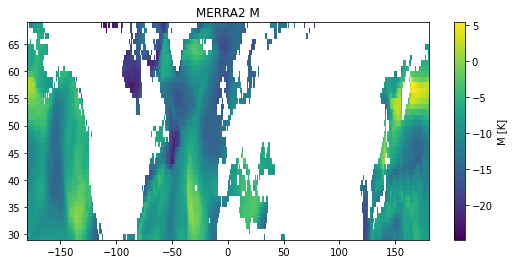

In [68]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(sfc_lon, p_sfc_lat, plot_CAOI[100,:,:])
plt.title('MERRA2 M')
cbar = plt.colorbar()
cbar.set_label('M [K]')

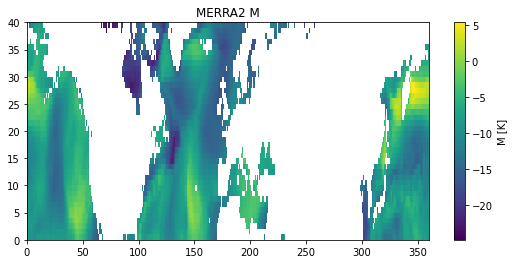

In [92]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(plot_CAOI[100,:,:])
plt.title('MERRA2 M')
cbar = plt.colorbar()
cbar.set_label('M [K]')

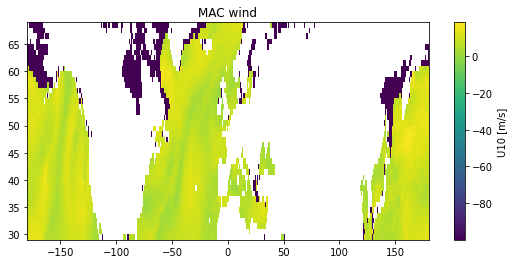

In [70]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(mac_lon, p_mac_lat, plot_wind[100,:,:]) #
plt.title('MAC wind')
cbar = plt.colorbar()
cbar.set_label('U10 [m/s]')

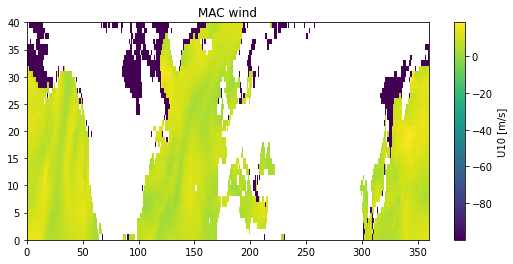

In [93]:
fig = plt.figure(figsize=(9,4))
plt.pcolormesh(plot_wind[100,:,:]) #
plt.title('MAC wind')
cbar = plt.colorbar()
cbar.set_label('U10 [m/s]')

In [31]:
o_indx = np.isnan(xx_new*yy_new)==False

In [32]:
o_M = xx_new[o_indx]
o_W = yy_new[o_indx]

In [41]:
o_W_bin_means, o_W_bin_edges, o_W_binnumber = stats.binned_statistic(o_M, o_W, 'mean', bins=100, range=(0,8))
o_M_bin_means, o_M_bin_edges, o_M_binnumber = stats.binned_statistic(o_M, o_M, 'mean', bins=100, range=(0,8))


Text(0.5, 1.0, 'U10 vs M for oceans between 30N to 80N/n0-8K')

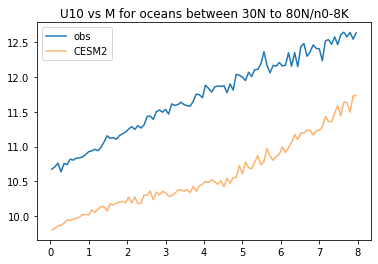

In [46]:
o_index = np.isnan(o_M_bin_means*o_W_bin_means)==False
    
plt.plot(o_M_bin_means[o_index], o_W_bin_means[o_index], label='obs')
plt.plot(g_M_bin_means[g_index], g_W_bin_means[g_index], label=modname[l], alpha=0.6)

plt.legend()
plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N/n0-8K')

In [53]:
yti = str(int(merlev[p_level]))

In [54]:
yti

'800'

# 30N 80N bias vs resolution 0-8K

In [47]:
g_lat_diff = np.abs(x_lat[1]-x_lat[0])

In [48]:
g_lon_diff = np.abs(x_lon[1]-x_lon[0])

In [49]:
g_res = (np.sqrt(g_lat_diff**2 + g_lon_diff**2)) * 110.574

In [50]:
g_res

173.0980628778057

In [51]:
o_lat_diff = np.abs(maclat[1]-maclat[0])
o_lon_diff = np.abs(maclon[1]-maclon[0])
o_res = (np.sqrt(o_lat_diff**2 + o_lon_diff**2)) * 110.574

In [52]:
o_res

156.37525044584262

In [53]:
o_final_M = o_M_bin_means[o_index]
o_final_W = o_W_bin_means[o_index]
g_final_M = g_M_bin_means[g_index]
g_final_W = g_W_bin_means[g_index]

In [57]:
print(np.max(o_final_M),np.min(o_final_M))

7.959523169902115 0.03982055553182486


In [59]:
print(np.max(g_final_M),np.min(g_final_M))

7.958889738701622 0.03961292786790069


In [60]:
bias = o_final_W - g_final_W

In [62]:
mean_bias = np.mean(bias)

In [63]:
mean_bias

1.1307205778304315

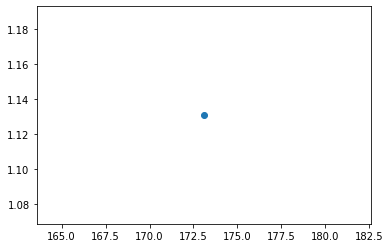

In [65]:
plt.scatter(g_res,mean_bias)

In [64]:
o_re_theta = o_final_M[o_final_M>0]
o_re_wind  = o_final_W[o_final_M>0]

In [70]:
o_res_theta = o_re_theta[o_re_theta<5]
o_res_wind  = o_re_wind[o_re_theta<5]

In [71]:
g_re_theta  = g_final_M[g_final_M>0]
g_re_wind   = g_final_W[g_final_M>0]
g_res_theta = g_re_theta[g_re_theta<5]
g_res_wind  = g_re_wind[g_re_theta<5]

In [78]:
o_M_bin_edges

array([-32.23164545, -32.22606642, -32.2204874 , ...,  23.54745384,
        23.55303287,  23.55861189])

In [77]:
g_M_bin_edges

array([-39.9986306 , -39.99267577, -39.98672094, ...,  19.53774535,
        19.54370018,  19.54965501])

In [72]:
print(np.max(g_res_theta), np.min(g_res_theta))
print(np.max(o_res_theta), np.min(o_res_theta))

4.999069630443148 0.003063943935968875
4.9943308057800095 0.0011585145791658286


In [75]:
bias = o_res_theta - g_res_theta

ValueError: operands could not be broadcast together with shapes (896,) (840,) 

In [74]:
np.mean(o_res_theta)

2.497787718645818

## 50S 50N oceans theta 800hPa

Text(0.5, 1.0, 'U10 vs M for oceans between -50N to 50N')

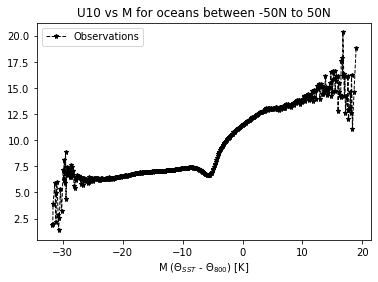

In [34]:
plt.plot(bin_means_x[index], bin_means[index], color='black' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='Observations')
plt.legend()
yti = str(int(merlev[p_level]))
plt.xlabel(r"M ($\Theta_{SST}$ - $\Theta_{"+yti+"})$ [K]")
plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N')


Text(0.5, 1.0, 'U10 vs M for oceans between -50N to 50N')

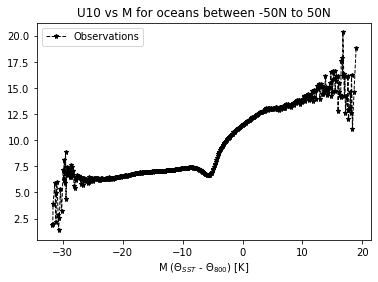

In [ ]:
plt.plot(bin_means_x[index], bin_means[index], color='black' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='Observations')
plt.legend()
yti = str(int(merlev[p_level]))
plt.xlabel(r"M ($\Theta_{SST}$ - $\Theta_{"+yti+"})$ [K]")
plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N')

## 30N 70N oceans theta 850hPa

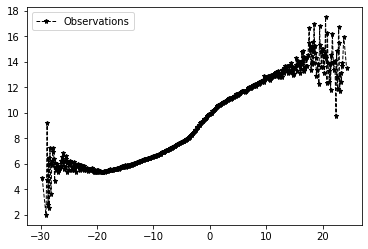

In [34]:
plt.plot(bin_means_x[index], bin_means[index], color='black' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='Observations')
plt.legend()

## 30N 70N oceans theta 800hPa

Text(0.5, 1.0, 'U10 vs M for oceans between 30N to 70N')

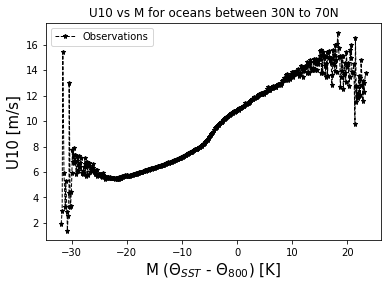

In [64]:
plt.plot(bin_means_x[index], bin_means[index], color='black' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='Observations')
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
yti = str(int(merlev[p_level]))
plt.xlabel(r"M ($\Theta_{SST}$ - $\Theta_{"+yti+"})$ [K]",fontsize='15')
plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N')

Text(0.5, 1.0, 'U10 vs M for oceans between 30N to 70N')

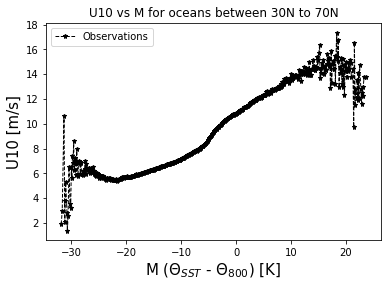

In [78]:
plt.plot(bin_means_x[index], bin_means[index], color='black' ,marker='*', linestyle='dashed',
     markersize=5,linewidth=1, label='Observations')
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
yti = str(int(merlev[p_level]))
plt.xlabel(r"M ($\Theta_{SST}$ - $\Theta_{"+yti+"})$ [K]",fontsize='15')
plt.title('U10 vs M for oceans between '+str(latr1)+'N to '+str(latr2)+'N')

In [ ]:
bin_means_x_obs = bin_means_x[index]
bin_means_obs   = lowess

In [ ]:
fig= plt.figure(figsize=(5, 6))
plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

# PPE

In [35]:
enn = np.arange(201,251)

In [36]:
ppe_var = ['U10', 'PSL', 'T850','TREFHT']

In [37]:
for en in enn:
    if en != 175:
        for i in ppe_var: #TREFHT was used since no TS. Should double check this.
            d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h1.'+str(i)+'.nc'
            data =xr.open_dataset(d_path)

            if en == enn[0]:
                lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
                lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
                time = data.variables['time'][:] #(time: 36)

            locals()[str(en)+'_'+i] = data.variables[i][:]

In [38]:
x_lat = np.array(lat)
lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (30)).argmin()])[0]
lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (70)).argmin()])[0]
lat_new  = lat[lat_ind1[0]:lat_ind2[0]]

mask = np.ones((1096,len(lat_new),len(lon)))

for a in range(len(lat_new)):
    for b in range(len(lon)):
        if globe.is_land(lat_new[a], lon[b]-180.)==True:
            mask[:,a,b] = 0

for en in enn:
    if en != 175:
        # print(en)
        for i in ppe_var: #
            tmp  = locals()[str(en)+'_'+i]
            tmp2 = tmp[0:1096,lat_ind1[0]:lat_ind2[0],:]
            locals()['MID'+i+'_'+str(en)] = np.multiply(mask,tmp2)

In [39]:
for en in enn:
    if en != 175:
        locals()['theta_850_'+str(en)] = np.multiply(locals()['MIDT850_'+str(en)],(np.divide(locals()['MIDPSL_'+str(en)],85000))**(Rd/Cp))

In [ ]:
np.shape(theta_850_247)

In [40]:
for en in enn:
    if en != 175:
        locals()['M_'+str(en)]   = np.array(np.subtract(locals()['MIDTREFHT_'+str(en)],locals()['theta_850_'+str(en)])).reshape(-1)
        locals()['U10_'+str(en)] = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)

In [ ]:
np.max(U10_246)

In [ ]:
from scipy import stats
from skmisc.loess import loess

Text(0.5, 0, 'CAOI [K]')

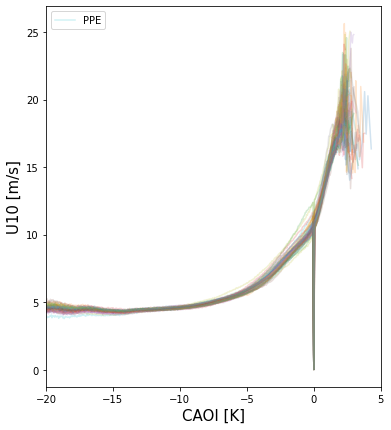

In [42]:
fig= plt.figure(figsize=(6, 7))
# plt.plot(bin_means_x_gcm, bin_means_gcm,color='magenta' ,marker='*', linestyle='dashed',
#      markersize=5,linewidth=1, label='CESM2') #marker='*', markersize=12,
# plt.plot(bin_means_x_obs, bin_means_obs,color='blue' ,marker='*', linestyle='dashed',
#      markersize=5,linewidth=1, label='Observations')
for en in enn:
    if en != 175:
        x = locals()['M_'+str(en)]
        y = locals()['U10_'+str(en)]
        ind = np.argsort(x)
        xx = np.sort(x)
        yy = y[ind]

        indx = np.isnan(xx*yy)==False

        bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=1000)
        bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=1000)

        index = np.isnan(bin_means_x*bin_means)==False

        # plt.plot(bin_means_x, bin_means)
#         l = loess(bin_means_x[index], bin_means[index])
#         l.fit()
#         pred = l.predict(bin_means_x[index], stderror=True)
#         conf = pred.confidence()

#         lowess = pred.values


        if en==250:
            plt.plot(bin_means_x[index], bin_means[index], alpha=0.2,label='PPE')

        else:
            plt.plot(bin_means_x[index], bin_means[index], alpha=0.2)
    

# plt.plot(bin_means_x_obs, bin_means_obs, label='MACLWP+MERRA2')
# plt.plot(bin_means_x_gcm, bin_means_gcm, label='CESM2')
# plt.xticks(np.arange(-20,6,5),fontsize='12')
# plt.yticks(np.arange(4,13),fontsize='12')
# plt.plot(bin_means_x_gcm, bin_means_gcm,color='magenta' ,marker='*', linestyle='dashed',
#      markersize=5,linewidth=1, label='CESM2')
# plt.plot(bin_means_x_obs, bin_means_obs,color='blue' ,marker='*', linestyle='dashed',
#      markersize=5,linewidth=1, label='Observations')
plt.xlim([-20,5])

plt.legend()
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('CAM6 PPE')
# plt.savefig('ppe.png')